# Open Source Energy Modeling - 3 rd Homework - Task 2

### *Adding a new technology: gas power plant*

The following simple energy model using *MESSAGEix* is based on the Westeros Baseline Tutorials, which can be found [here](https://message.iiasa.ac.at/en/stable/tutorials.html). The baseline model was adaped by adding gas power plant as a new technology. In the secound part of the task, a CO2 bound was added to the model in order to determine a Carbon price under which Gas, Wind and Coal are used at the same time. For this the tutorials westeros_emissions_bounds and westeros_emissions_taxes were used.


## Part 1a - Adding gas power and defining parameters 



Like in the tutorial all the packages are imported. The *ixmp* `Platform` is your connection to a database for storing model input data and scenario results.

In [504]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [505]:
mp = ixmp.Platform()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/Luisa/.local/share/ixmp/localdb/default


A new `Scenario` is created to build our model.

In [506]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline', version='new')

The model structure defining time and space is kept like in the tutorial.

In [507]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon({'year': history + model_horizon,  
                      'firstmodelyear': model_horizon[0]})

In [508]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

A new technology called Gas is added.

In [509]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['coal_ppl', 'wind_ppl', 'gas_ppl','grid', 'bulb'])
scenario.add_set("mode", "standard")

### Supply and Demand

The GDP profile is kept the same.

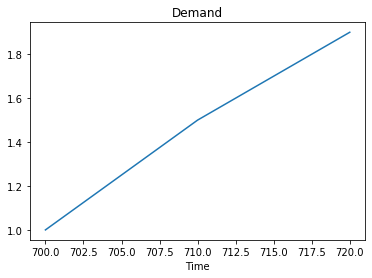

In [510]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

The demand is taken from the tutorial:

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)


In [511]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

In [512]:
scenario.add_par("demand", light_demand)

In order to define the input and output commodites of each technology, some common keys are defined.

In [513]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [514]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0)
scenario.add_par('input', bulb_in)

Because the grid has transmission losses, only 90% of the input electricity is available as output.

In [515]:
grid_efficiency = 0.9
grid_out = make_df(base_output, technology='grid', commodity='electricity', 
                   level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',
                  level='secondary', value=1.0)
scenario.add_par('input', grid_in)

In- and Output of the new gas plant is added. (The model does not include the fossil resources used as `input` for coal plants; however, costs of coal extraction are included in the parameter $variable\_cost$.)

In [516]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', coal_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', wind_out)

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity',
                  level='secondary', value=1.)
scenario.add_par('output', gas_out)

### Operational constraints

Alike coal the `capacity_factor` for gas is set to 1 as it is assumed that all installed capacity can be active at all time.

In [517]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [518]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'gas_ppl': 1,
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

The `technical_lifetime` for a gas plant is added. The technical lifetime of a gas power plant is assumed to be 30 yrs. This information is taken from the [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4). 

In [519]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [520]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'gas_ppl': 30,
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

### Technological Diffusion and Contraction

Alike in the tutorial all technologies (incl. Gas) are limited in their ability to grow. The constraint is set at 10% per year.

In [521]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [522]:
growth_technologies = [
    "coal_ppl", 
    "wind_ppl",
    "gas_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scenario.add_par('growth_activity_up', df)

## Part 1b - Defining Energy Mix 

In the following part the energy mix is defined. For this model the a mix of 40% Wind (same as tutorial), 40% coal and 20% gas was chosen.

In [523]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.4

In [524]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [525]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': 0.4 * historic_generation,
    'gas_ppl': 0.2 * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In [526]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 3, # 30 year lifetime!
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

## Part 1c - Adding costs (Objective Function)

For the following cost parameters it is assumed that the gas plants run using combined-cycle gas turbines (CCGT). The reagarding costs are again taken from the [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4). 


The interest rate parameter is kept the same.

In [527]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit='-')

### Investment Costs

The investment costs are assumed to be 1100 $/kW  ([IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4))


In [528]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [529]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'gas_ppl': 1100,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

The fixes O&M costs are assumed to be 44 $/kW/a ([IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4))

In [530]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [531]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'coal_ppl': 30,
    'gas_ppl': 44,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

[IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) only states fixed and variable costs being 44 $/kW/a. Therefore this number is used as variable O&M costs even this doesn't match the units of the tutorial (but we can assume that they produce 8760h per year). 

In [532]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [533]:
costs = {
    'coal_ppl': 30,
    'gas_ppl': 44,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario.add_par('var_cost', df)

### Solving the Model

In [534]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))

scenario.commit(comment='basic model of Westeros electrification')

log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 30


In [535]:
scenario.set_as_default()

In [536]:
scenario.solve()

In [537]:
scenario.var('OBJ')['lvl']

251027.28125

### Plotting Results
As seen in the following plot, the three technologys do not coexist in the year 720 anymore. This will bechanged by introducing an emissiobn bound in the 2nd Part.

In [538]:
from tools import Plots
p = Plots(scenario, country, firstyear=model_horizon[0])

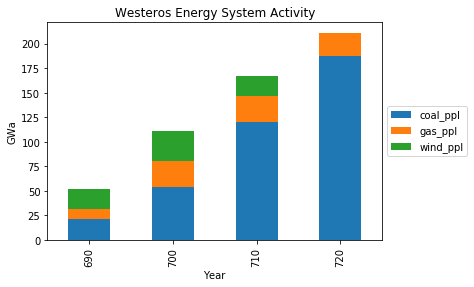

In [539]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

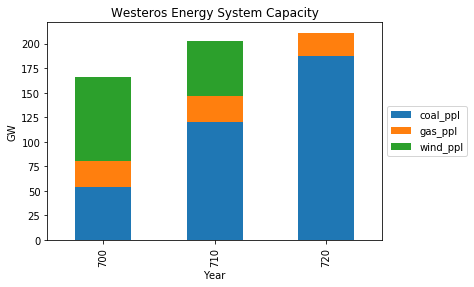

In [540]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

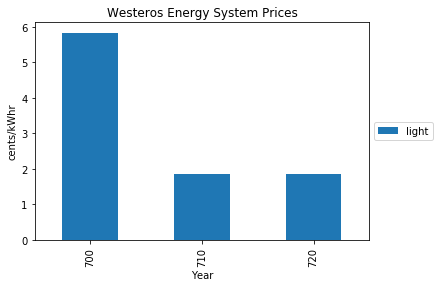

In [541]:
p.plot_prices(subset=['light'], baseyear=True)

In [542]:
mp.close_db()

## Part 2a - Adding Emission Bound
For the following part the baseline senario is clones and an upper bound on emissions is introduced. As a next step the emissions bound is adapted in a way that the three technologies coexisted throughout the model horizon.

In [543]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [544]:
mp = ixmp.Platform()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/Luisa/.local/share/ixmp/localdb/default


In [545]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'emission_bound','introducing an upper bound on emissions',
                  keep_solution=False)
scen.check_out()

In [546]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

### Introducing Emissions

The [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) states that CCGT plant cause CO2 emissions of 340 kgCO2/MWh. Convertig this value into tCO2/kWa this gives 2,98 tCo2/kWa. The emission factor for gas is added in the cell below.

In [547]:
# emission of CO2 and the emission category GHG are introduced
scen.add_set('emission', 'CO2')
scen.add_cat('emission', 'GHG', 'CO2')


base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/kWa',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/kWa')
mp.add_unit('MtCO2')

# adding CO2 emissions to the coal and gas powerplant
emission_factor_tech = {
    'coal_ppl': 7.4,
    'gas_ppl': 3.98,
    'wind_ppl': 0,
}

for tec, val in emission_factor_tech.items():
    emission_factor = make_df(base_emission_factor, technology=tec, emission= 'CO2', value =val)
    scen.add_par('emission_factor', emission_factor)

INFO:root:unit `tCO2/kWa` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


### Define a Bound on Emissions

In the tutorial the emission bound was originally set to 500 MtCO2 over the entire model horizon. With this value, coal cannot exist in the last year (720). The emission bound is therefore increased in steps of 50 MtCO2 until coal apprears in the year 720.

In [548]:
scen.add_par('bound_emission', [country, 'GHG', 'all', 'cumulative'],
             value=700., unit='MtCO2')

In [549]:
scen.commit(comment='introducing emissions and setting an upper bound')
scen.set_as_default()

In [550]:
scen.solve()

In [551]:
scen.var('OBJ')['lvl']

284576.8125

### Plotting Results

In [552]:
from tools import Plots
p = Plots(scen, country, firstyear=700)

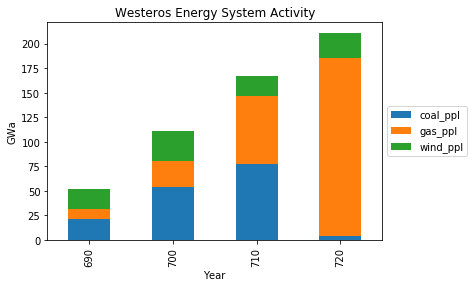

In [553]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl','gas_ppl'])

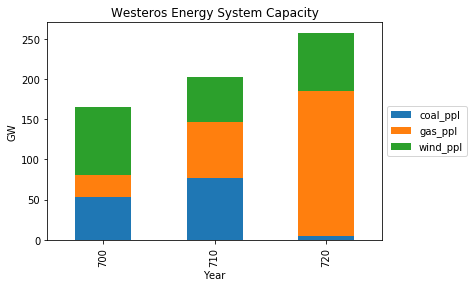

In [554]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl', 'gas_ppl'])

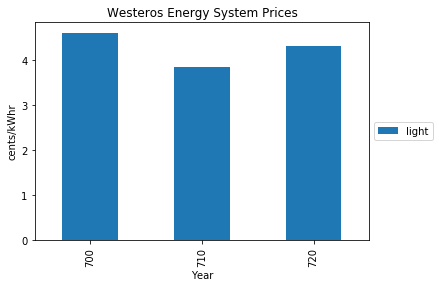

In [555]:
p.plot_prices(subset=['light'], baseyear=True)

In [556]:
mp.close_db()